# Block solver for OTI numbers.
```
Author: Mauricio Aristizabal Cano
D. Eng. Candidate.
Universidad EAFIT
Medellín, Colombia.

Last update: 2019/11/28
```


## Introduction

This document is designed to test the behavior of the block solver approach on different conditions, comparing it to a symbolic librarie Sympy.

In [1]:
# 1. SET GLOBAL PATH 
import sys
path2oti = '../../../build/'
sys.path.append(path2oti) # Add path to OTI library.

from IPython.display import display, Math

# Utility to render math latex
def display_string(string, head = "", tail = ""):
    display(Math(head+string+tail))
# end 

def eval_sym_expr(expr,syms, vals):
    res = expr
    for i in range(len(syms)):
        res = res.replace(syms[i],vals[i])
    # end for
    return res.doit().evalf()
# end eval_sym_expr

from pyoti.core import dhelp_get_matrix_form, imdir

import pyoti.dense as oti

import numpy as np
np.set_printoptions(linewidth=120)

import sympy as sym
sym.init_printing()

import sympy.matrices as smat

## Block solver approach.

The block solver approach is a methodology to solve the OTI system of equations more efficiently, by using LU decomposition to solve the multiple derivatives of a system, since they might be solved by using the same matrix of coefficients as the real system of equations.

An example of this system of equations is shown below. The system of equations is the following for a system of 2 variables and computation of 2nd order derivatives:


In [2]:
nvars  = 3 # Number of variables to compute derivatives.
dorder = 2 # Order of the derivative required in the analysis.

display_string(oti.solve_latex(nvars,dorder))

<IPython.core.display.Math object>

## Test system of equations
The system to be solved as an example is a system that depends on 3 variables $\alpha$, $\beta$, $\gamma$. The system of equations is also sparse and has 5 equations and 5 variables.

$$
\begin{align}
3 x_1 + \frac{\beta}{\gamma} x_2& = 3\alpha \\  %eq1 
\beta^2 x_2 + \frac{5}{\beta^2} x_{5}& = 4  \\  %eq2
\alpha x_1 - \alpha \gamma x_5 & = 17  \\  %eq3
18 x_1 + x_4 & = \alpha + \beta + \gamma  \\  %eq4
19 x_3 - \beta x_4 & = \gamma \\  %eq5
\end{align}
$$

The matrix system of equations is:
$$
\begin{bmatrix}
3 & \frac{\beta}{\gamma} & 0 & 0 & 0 \\  %eq1 
0 & \beta^2 &0 & 0 &\frac{5}{\beta^2}   \\  %eq2
\alpha& 0&0&0&- \alpha \gamma   \\  %eq3
18 & 0 & 0& 1 & 0 \\  %eq4
0 & 0 & 19 & -\beta & 0 \\  %eq5
\end{bmatrix}
\begin{bmatrix}
x_1 \\
x_2 \\
x_3 \\
x_4 \\
x_5 \\
\end{bmatrix}
=
\begin{bmatrix}
3\alpha \\  %eq1 
4  \\  %eq2
17  \\  %eq3
\alpha + \beta + \gamma  \\  %eq4
\gamma \\  %eq5
\end{bmatrix}
$$


The main goal is to compute the derivatives up to second order of $x_1$, $...$, $x_5$ with respect to $\alpha$ $\beta$ and $\gamma$

In [3]:
# Desired evaluation point.

α = 2.5
β = 0.8
γ = 7.6

In [4]:
# function that sets up the positions
def setup_A(A, alpha, beta, gamma):
    
    A[0,0] = 3
    A[0,1] = beta/gamma
    A[1,1] = beta**2
    A[1,4] = 5/beta**2
    A[2,0] = alpha
    A[2,4] = -alpha*gamma
    A[3,0] = 18
    A[3,3] = 1
    A[4,2] = 19
    A[4,3] = -beta

# end setup_A

#function that sets the positions of b
def setup_b(b, alpha, beta, gamma):
    
    b[0,0] = 3*alpha
    b[1,0] = 4.0
    b[2,0] = 17.0
    b[3,0] = alpha + beta + gamma
    b[4,0] = gamma

# end setup_b

## Conventional system, using real solvers

In [5]:
# Generate the conventional real system of equations.

A_re = np.zeros((5,5))
b_re = np.zeros((5,1))

setup_A(A_re, α, β, γ)
setup_b(b_re, α, β, γ)

print("A:\n",A_re)
print("\nb:\n",b_re)

A:
 [[  3.           0.10526316   0.           0.           0.        ]
 [  0.           0.64         0.           0.           7.8125    ]
 [  2.5          0.           0.           0.         -19.        ]
 [ 18.           0.           0.           1.           0.        ]
 [  0.           0.          19.          -0.8          0.        ]]

b:
 [[ 7.5]
 [ 4. ]
 [17. ]
 [10.9]
 [ 7.6]]


In [6]:
x_re = np.linalg.solve(A_re,b_re)
print("\nx:\n",x_re)


x:
 [[  2.01079416]
 [ 13.9423665 ]
 [ -0.66502294]
 [-25.29429484]
 [ -0.63015866]]


## Using symbolic library

In [7]:
α_s = sym.symbols("alpha")
β_s = sym.symbols("beta")
γ_s = sym.symbols("gamma")

A_s = sym.zeros(5)
b_s = sym.zeros(5)[:,[0]]

setup_A( A_s, α_s, β_s, γ_s)
setup_b( b_s, α_s, β_s, γ_s)

print("A:")
print(repr(A_s))
print("")
print("b:")
print(repr(b_s))

A:
Matrix([
[    3, beta/gamma,  0,     0,            0],
[    0,    beta**2,  0,     0,    5/beta**2],
[alpha,          0,  0,     0, -alpha*gamma],
[   18,          0,  0,     1,            0],
[    0,          0, 19, -beta,            0]])

b:
Matrix([
[             3*alpha],
[                 4.0],
[                17.0],
[alpha + beta + gamma],
[               gamma]])


In [8]:
x_s = A_s.LUsolve(b_s)

All derivatives are extracted and stored in a similar fashion to the conventional OTI numbers.

In [9]:
# Get first order derivatives first
dxdα_s = x_s.diff(α_s,1).diff(β_s,0).diff(γ_s,0)
dxdβ_s = x_s.diff(α_s,0).diff(β_s,1).diff(γ_s,0)
dxdγ_s = x_s.diff(α_s,0).diff(β_s,0).diff(γ_s,1)

dxdαdα_s = x_s.diff(α_s,2).diff(β_s,0).diff(γ_s,0)
dxdαdβ_s = x_s.diff(α_s,1).diff(β_s,1).diff(γ_s,0)
dxdβdβ_s = x_s.diff(α_s,0).diff(β_s,2).diff(γ_s,0)
dxdαdγ_s = x_s.diff(α_s,1).diff(β_s,0).diff(γ_s,1)
dxdβdγ_s = x_s.diff(α_s,0).diff(β_s,1).diff(γ_s,1)
dxdγdγ_s = x_s.diff(α_s,0).diff(β_s,0).diff(γ_s,2)

# stored as an otinum.
dx_s =[]
dx_s.append([x_s]) # Function
dx_s.append([dxdα_s,dxdβ_s,dxdγ_s]) # First order derivatives
dx_s.append([dxdαdα_s,dxdαdβ_s,dxdβdβ_s,dxdαdγ_s,dxdβdγ_s,dxdγdγ_s]) # Second order derivatives.


syms = [α_s,β_s,γ_s]
vals = [α,β,γ]


# def compute_all_derivs_sympy(fun, vars, order):
#     """
#     PORPUSE: This is an utility function to compute all derivatives up to order n of a symbolic function
#              "relatively efficiently". 
             
#     """
#     fd_s = []
    
#     # append first the function itself
#     fd_s.append([fd_s])
    
#     # iterate through all orders.
#     for ordi in range(order):
        
#         fd_s.append([])
        
#         ordj=ordi+1
#         for i in range(vars):

#             fd_s[ordj].append( fd_s[ordi].diff() )
    
    
    
    
    


In [10]:
α_oti = α + oti.e(1,nbases=nvars, order=dorder)
β_oti = β + oti.e(2,nbases=nvars, order=dorder)
γ_oti = γ + oti.e(3,nbases=nvars, order=dorder)

A_oti = oti.zeros(5,5,nbases=nvars, order=dorder)
b_oti = oti.zeros(5,1,nbases=nvars, order=dorder)

setup_A(A_oti,α_oti,β_oti,γ_oti)
setup_b(b_oti,α_oti,β_oti,γ_oti)

print("A:")
print(repr(A_oti))
print("\nb:")
print(repr(b_oti))

A:
omat<shape: (5, 5), ndir: 9, order: 2, re:
array([[  3.        ,   0.10526316,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.64      ,   0.        ,   0.        ,   7.8125    ],
       [  2.5       ,   0.        ,   0.        ,   0.        , -19.        ],
       [ 18.        ,   0.        ,   0.        ,   1.        ,   0.        ],
       [  0.        ,   0.        ,  19.        ,  -0.8       ,   0.        ]])>

b:
omat<shape: (5, 1), ndir: 9, order: 2, re:
array([[ 7.5],
       [ 4. ],
       [17. ],
       [10.9],
       [ 7.6]])>


In [11]:
x_oti = oti.solve(A_oti,b_oti)

[[  1.22217083]
 [ -6.33186876]
 [ -0.88417158]
 [-20.999075  ]
 [  0.51870669]]


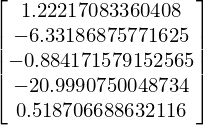

In [12]:
# Derivative obtained by oti algebra:
print(x_oti.get_deriv(1))
eval_sym_expr(dxdα_s,syms,vals)

In [13]:
deriv_idx = [[0],
            [1],
            [2],
            [3],
            [[1,2]],
            [1,2],
            [[2,2]],
            [1,3],
            [2,3],
            [[3,2]]]

for i in range(len(deriv_idx)):
    idx,order = imdir(deriv_idx[i])
    oti_der = x_oti.get_deriv(deriv_idx[i])    
    f = eval_sym_expr(dx_s[order][idx],syms,vals) 
    f = np.array(f,dtype = np.float64)
    print("Evaluating derivative:", str(deriv_idx[i]).replace(" ",""),
          "\tMaximum error: ",      np.max(np.abs(oti_der-f)/np.abs(f))
         )
    

Evaluating derivative: [0] 	Maximum error:  1.2740712559838438e-16
Evaluating derivative: [1] 	Maximum error:  2.8054227075308774e-16
Evaluating derivative: [2] 	Maximum error:  2.525196958954199e-16
Evaluating derivative: [3] 	Maximum error:  1.434183362088409e-15
Evaluating derivative: [[1,2]] 	Maximum error:  2.3980175716945915e-16
Evaluating derivative: [1,2] 	Maximum error:  2.389202815795413e-16
Evaluating derivative: [[2,2]] 	Maximum error:  5.142102514587861e-16
Evaluating derivative: [1,3] 	Maximum error:  4.433091162120394e-16
Evaluating derivative: [2,3] 	Maximum error:  5.398363980109192e-16
Evaluating derivative: [[3,2]] 	Maximum error:  1.4720989635040727e-16


In [14]:
# The same system but using sparse omat class

A_soti = oti.spr_omat((5,5),nbases = nvars, order=dorder )

setup_A(A_soti,α_oti,β_oti,γ_oti)

print(A_soti)

< spr_omat class, shape: (5,5), ndir: 34, nbases: 3, order: 4, 
  (0, 0)	3.0
  (0, 1)	0.10526315789473685
  (1, 1)	0.6400000000000001
  (1, 4)	7.812499999999999
  (2, 0)	2.5
  (2, 4)	-19.0
  (3, 0)	18.0
  (3, 3)	1.0
  (4, 2)	19.0
  (4, 3)	-0.8
+ e([1]) * 
  (2, 0)	1.0
  (2, 4)	-7.6
+ e([2]) * 
  (0, 1)	0.13157894736842105
  (1, 1)	1.6
  (1, 4)	-19.531249999999993
  (4, 3)	-1.0
+ e([3]) * 
  (0, 1)	-0.013850415512465375
  (2, 4)	-2.5
+ e([[1,2]]) * 

+ e([1,2]) * 

+ e([[2,2]]) * 
  (1, 1)	1.0
  (1, 4)	36.621093749999986
+ e([1,3]) * 
  (2, 4)	-1.0
+ e([2,3]) * 
  (0, 1)	-0.01731301939058172
+ e([[3,2]]) * 
  (0, 1)	0.0018224230937454442
+ e([[1,3]]) * 

+ e([[1,2],2]) * 

+ e([1,[2,2]]) * 

+ e([[2,3]]) * 

+ e([[1,2],3]) * 

+ e([1,2,3]) * 

+ e([[2,2],3]) * 

+ e([1,[3,2]]) * 

+ e([2,[3,2]]) * 

+ e([[3,3]]) * 

+ e([[1,4]]) * 

+ e([[1,3],2]) * 

+ e([[1,2],[2,2]]) * 

+ e([1,[2,3]]) * 

+ e([[2,4]]) * 

+ e([[1,3],3]) * 

+ e([[1,2],2,3]) * 

+ e([1,[2,2],3]) * 

+ e([[2,3],3]) * 

In [15]:
x_soti = oti.spsolve(A_soti,b_oti,solver='ILU')

In [16]:
for i in range(len(deriv_idx)):
    idx,order = imdir(deriv_idx[i])
    oti_der = x_soti.get_deriv(deriv_idx[i])    
    f = eval_sym_expr(dx_s[order][idx],syms,vals) 
    f = np.array(f,dtype = np.float64)
    print("Evaluating derivative:", str(deriv_idx[i]).replace(" ",""),
          "\tMaximum error: ",      np.max(np.abs(oti_der-f)/np.abs(f))
         )

Evaluating derivative: [0] 	Maximum error:  1.7618150619389758e-16
Evaluating derivative: [1] 	Maximum error:  2.1403676662680635e-16
Evaluating derivative: [2] 	Maximum error:  1.6289713998684936e-16
Evaluating derivative: [3] 	Maximum error:  1.434183362088409e-15
Evaluating derivative: [[1,2]] 	Maximum error:  7.318168858931245e-16
Evaluating derivative: [1,2] 	Maximum error:  5.029900664832448e-16
Evaluating derivative: [[2,2]] 	Maximum error:  3.428068343058574e-16
Evaluating derivative: [1,3] 	Maximum error:  3.632775567938643e-16
Evaluating derivative: [2,3] 	Maximum error:  5.398363980109192e-16
Evaluating derivative: [[3,2]] 	Maximum error:  4.492489512646705e-16


In [17]:
A_soti

<spr_omat, shape: (5,5), ndir: 34, nbases: 3, order: 4, spr_type: csr>

In [18]:
# works!

In [19]:
%timeit np.linalg.solve(A_re,b_re)

9.56 µs ± 70 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [20]:
%timeit A_s.LUsolve(b_s)

2.13 ms ± 33.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [21]:
%timeit oti.solve(A_oti,b_oti)

1.08 ms ± 6.53 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [22]:
%timeit oti.spsolve(A_soti,b_oti,solver='lu')

5.21 ms ± 52.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
